# Finding blobs in 64x64 images using conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import os.path

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data='/home/ubuntu/SAS_StemCell/'

In [3]:
def format_raw_image(img, shp):
    rtn=img
    slices=shp[0]
    width=shp[1]
    height=shp[2]
    channels=shp[3]
    frames=rtn.shape[0]/slices/width/height/channels
    frames=int(frames)
    rtn=rtn.reshape([frames, slices, channels, width, height])

    rtn=np.swapaxes(np.swapaxes(rtn,2,3),3,4)
    if (slices==1):
        rtn=rtn.reshape(frames, width, height, channels)
    if (channels==1):
        rtn=rtn.reshape(frames, slices, width, height)
    if (slices==1 and channels==1):
        rtn=rtn.reshape(frames, width, height)
    return rtn

#shp=[slices, width, height, channels]
def get_raw_float_image(fname, shp):
    rtn=np.fromfile(fname, np.float32)
    rtn=rtn.byteswap()
    rtn=format_raw_image(rtn,shp)
    return rtn

In [125]:
def plot_4x1(g1, g2, g3, g4):
    f,axes=plt.subplots(1,4, figsize=(10,10))
    axes[0].imshow(g1)
    axes[1].imshow(g2)
    axes[2].imshow(g3)
    axes[3].imshow(g4)


# Get data

Data reading function

In [4]:
shp=[1,64,64,4]

In [5]:
good_data=get_raw_float_image(data+'goodv2_segmentation.tif_RotShift_img.raw', shp)[:,:,:,0:3]/4096.0

In [6]:
good_masks=get_raw_float_image(data+'goodv2_segmentation.tif_RotShift_masks.raw', [1,64,64,2])/255.0

In [7]:
bad_data=get_raw_float_image(data+'bad_subsetv2.raw', shp)[:,:,:,0:3]/4096.0

In [47]:
tricky_data=get_raw_float_image(data+'Trickies_RotShift.raw', shp)[:,:,:,0:3]/4096.0

Setup training set (training_*)

In [48]:
def get_data_and_truths(goods, bads, trickies):
    good_subset=good_data[goods,:,:,:]
    good_mask_subset=good_masks[goods,:,:,:]
    bad_subset=bad_data[bads, :,:,:]
    tricky_subset=tricky_data[trickies,:,:,:]
    
    my_list=np.concatenate((good_subset, bad_subset, tricky_subset), axis=0)
    my_truth=np.concatenate((good_mask_subset,np.zeros([len(bads), shp[1], shp[2], 2]), np.zeros([len(trickies), shp[1], shp[2], 2])), axis=0)
    return (my_list, my_truth)

In [130]:
training_list,training_truth=get_data_and_truths(np.arange(0,55*201), np.arange(0,40000), np.arange(0,3000))

In [67]:
validation_list,validation_truth=get_data_and_truths(np.arange(55*201,65*201), np.arange(60000,67000), np.arange(3000,3500))

In [68]:
test_list,test_truth=get_data_and_truths(np.arange(65*201,70*201), np.arange(47000,49000), np.arange(3500,4000))

# Design network

In [96]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,3])
y=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,2])

xr=x
yr=y

base_scaler=32

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.contrib.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.contrib.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.contrib.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.contrib.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.contrib.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.contrib.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.contrib.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=utils.leaky_relu(tf.contrib.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
F1=utils.leaky_relu(tf.contrib.layers.conv2d(F0, 16*base_scaler, [3,3], padding='SAME'))
F2=utils.leaky_relu(tf.contrib.layers.conv2d(F1, 16*base_scaler, [3,3], padding='SAME'))



#Coming up
EE0=tf.contrib.layers.conv2d_transpose(F2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
EE1=tf.concat(axis=3, values=[EE0,E2])
EE2=utils.leaky_relu(tf.contrib.layers.conv2d(EE1, 8*base_scaler, [3,3], padding='SAME'))
EE3=utils.leaky_relu(tf.contrib.layers.conv2d(EE2, 8*base_scaler, [3,3], padding='SAME'))

DD0=tf.contrib.layers.conv2d_transpose(EE2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.contrib.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=utils.leaky_relu(tf.contrib.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.contrib.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.contrib.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=utils.leaky_relu(tf.contrib.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.contrib.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.contrib.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=utils.leaky_relu(tf.contrib.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.contrib.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=utils.leaky_relu(tf.contrib.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=utils.leaky_relu(tf.contrib.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

logits=utils.leaky_relu(tf.contrib.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
probs=tf.tanh(logits)

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
OutError, MaskError=tf.split(LSQ, [1,1], 3)
loss=10*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)

train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


# Training on easy set

0
Training loss:  0.19828983
Validation loss:  0.20874907


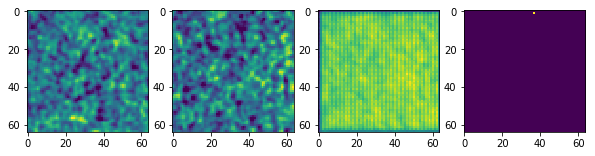

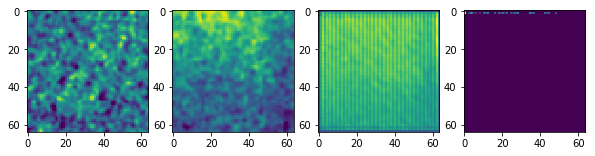

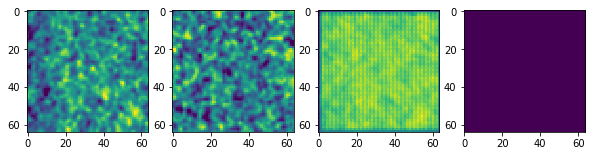

30
Training loss:  0.19318584
Validation loss:  0.14374681


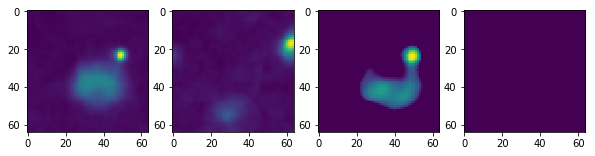

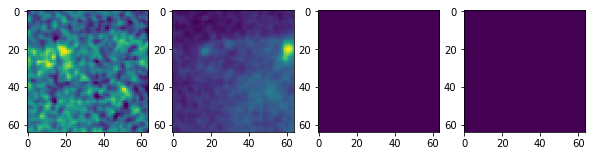

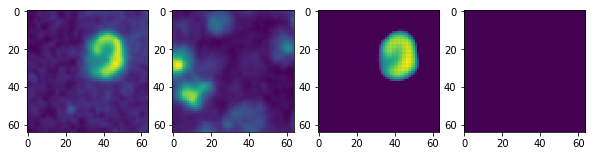

60
Training loss:  0.13385329
Validation loss:  0.16994727


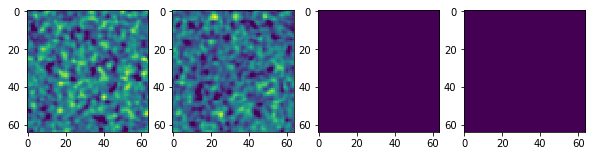

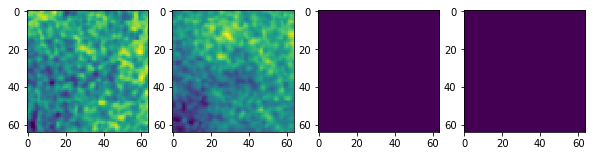

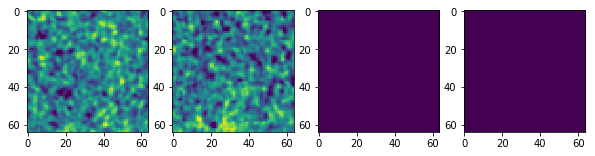

90
Training loss:  0.1102487
Validation loss:  0.10936905


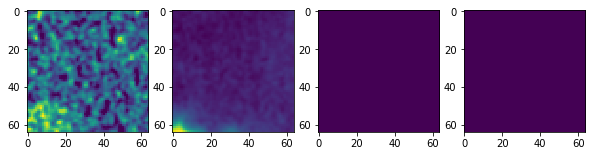

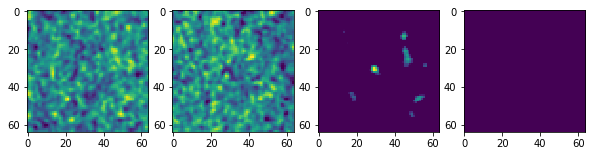

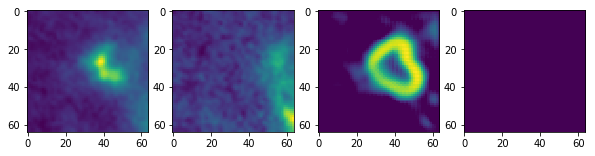

120
Training loss:  0.075970955
Validation loss:  0.10822842


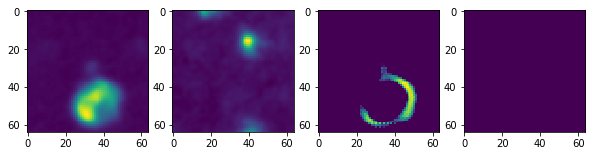

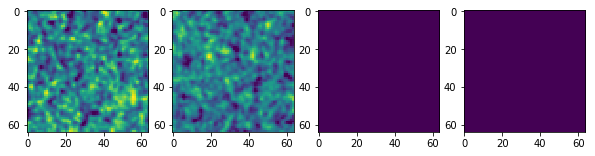

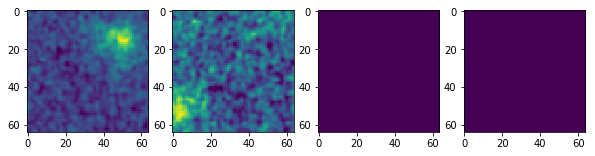

150
Training loss:  0.06304399
Validation loss:  0.07012401


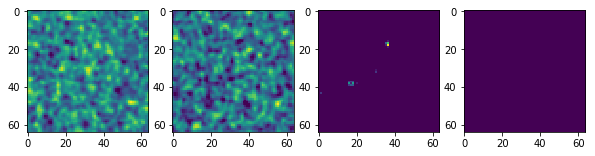

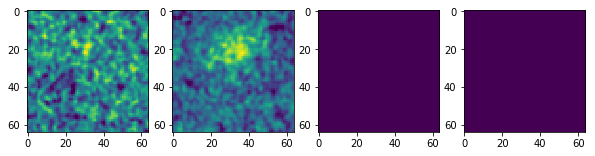

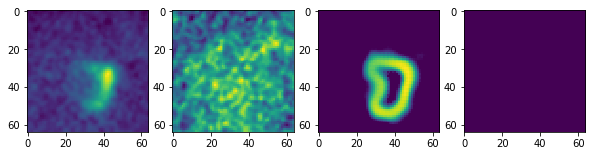

180
Training loss:  0.05783204
Validation loss:  0.07729588


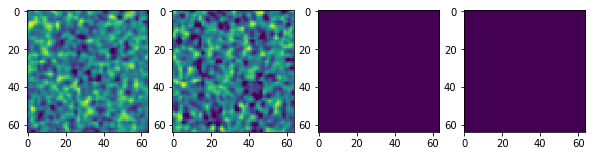

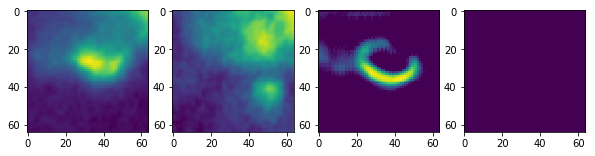

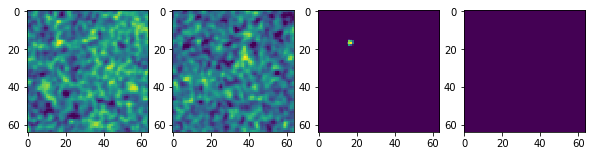

210
Training loss:  0.06803402
Validation loss:  0.07455807


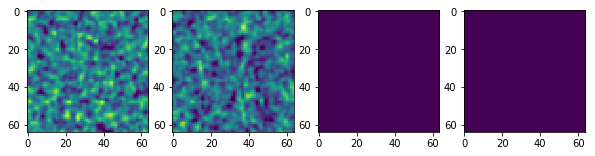

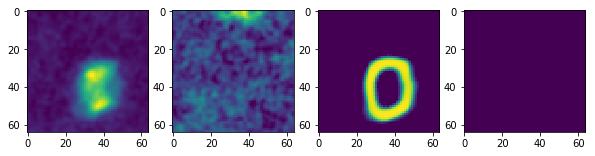

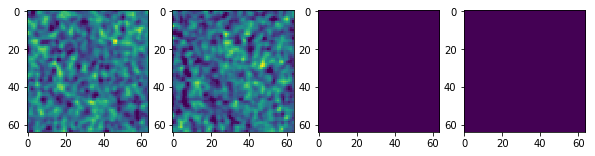

240
Training loss:  0.049133714
Validation loss:  0.073493935


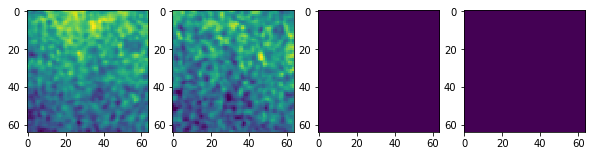

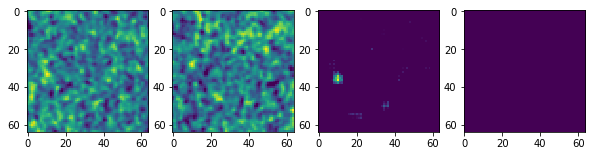

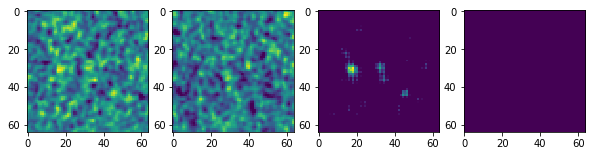

270
Training loss:  0.047388487
Validation loss:  0.08435874


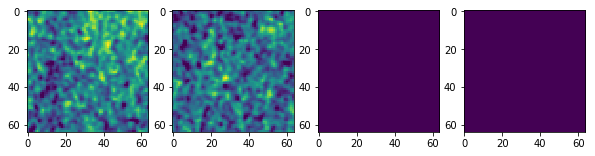

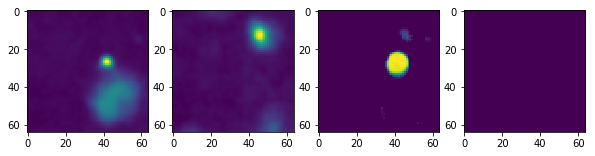

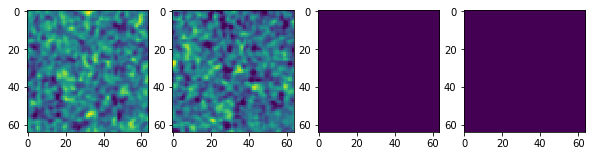

300
Training loss:  0.043131195
Validation loss:  0.09251771


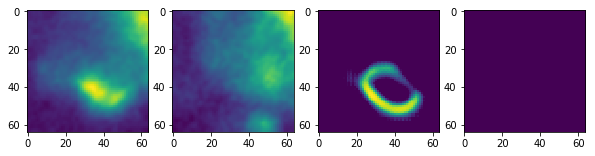

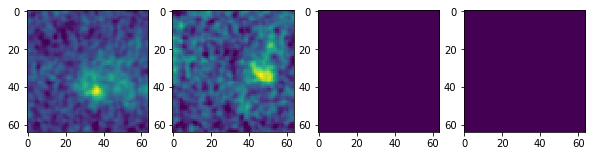

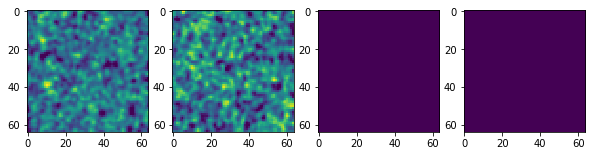

330
Training loss:  0.043452885
Validation loss:  0.07280796


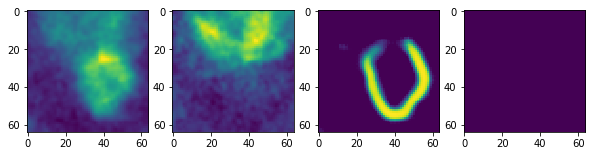

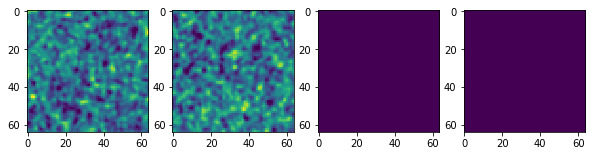

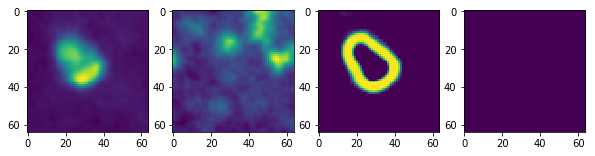

360
Training loss:  0.033816673
Validation loss:  0.07845902


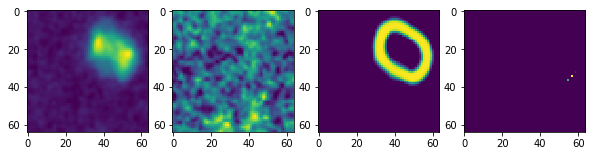

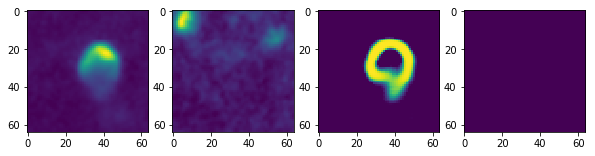

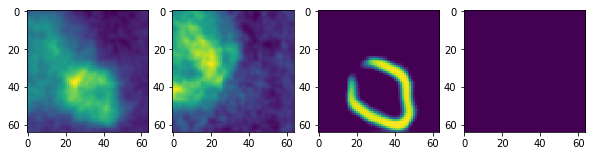

390
Training loss:  0.035658877
Validation loss:  0.09084146


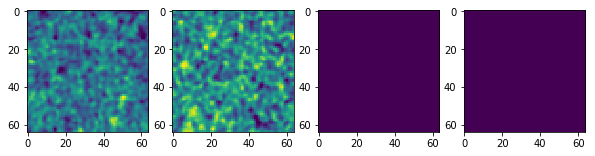

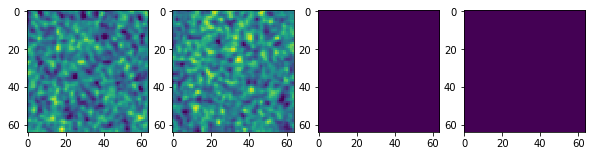

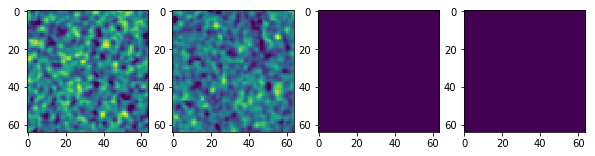

420
Training loss:  0.04203539
Validation loss:  0.08286433


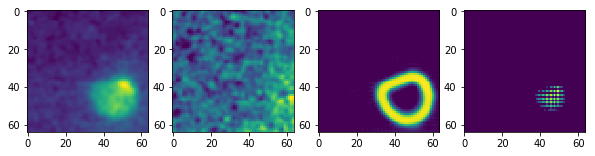

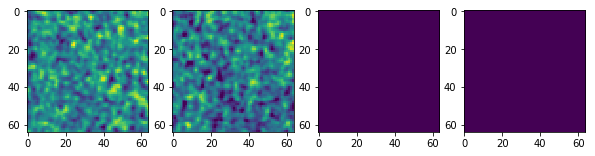

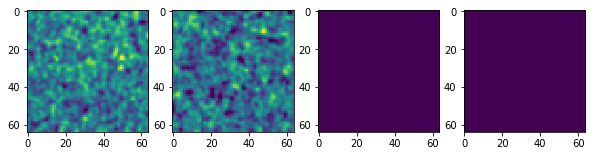

450
Training loss:  0.025214937
Validation loss:  0.08640667


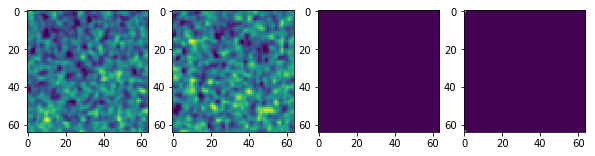

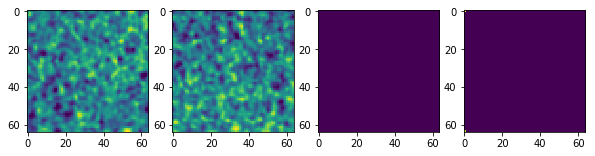

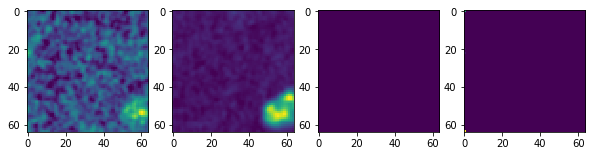

480
Training loss:  0.0208899
Validation loss:  0.066395506


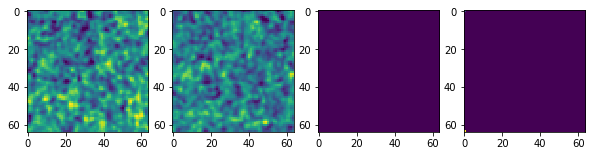

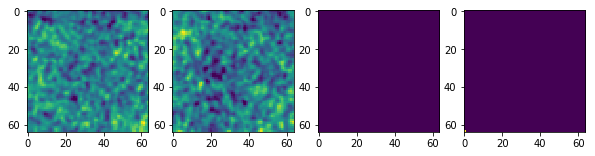

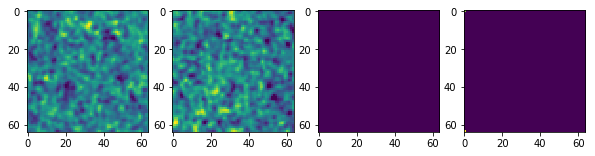

510
Training loss:  0.029903397
Validation loss:  0.08169752


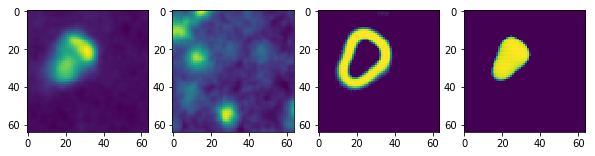

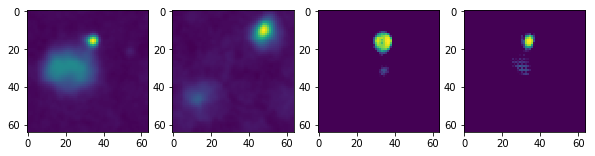

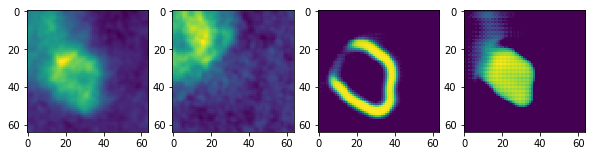

540
Training loss:  0.022765227
Validation loss:  0.0698373


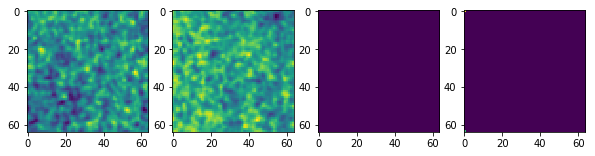

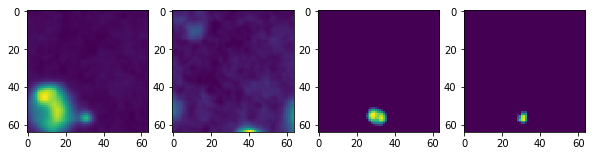

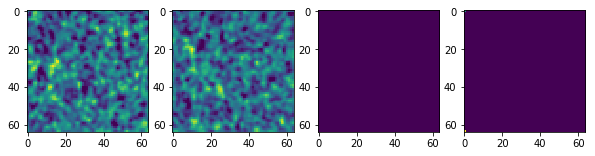

570
Training loss:  0.019051027
Validation loss:  0.0926851


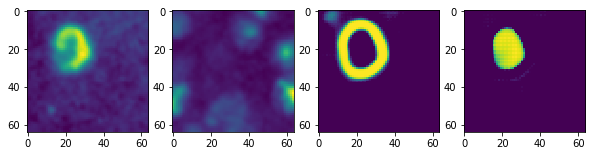

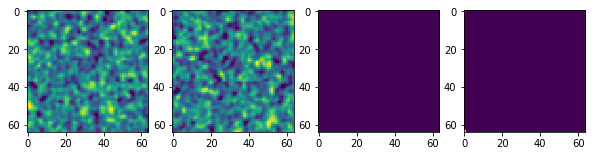

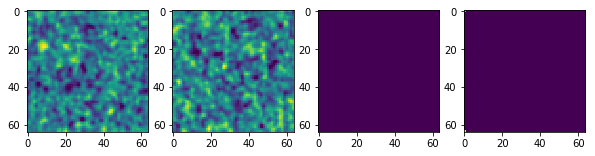

600
Training loss:  0.017063309
Validation loss:  0.076173715


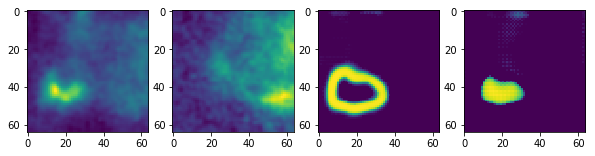

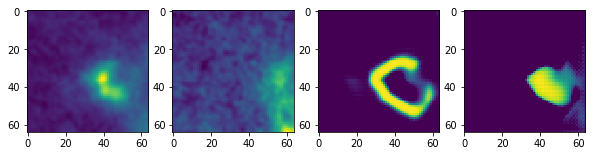

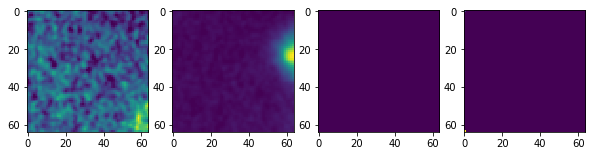

630
Training loss:  0.015797561
Validation loss:  0.07198416


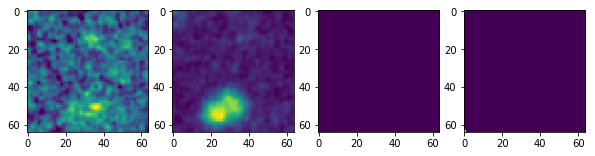

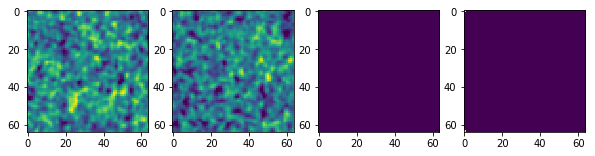

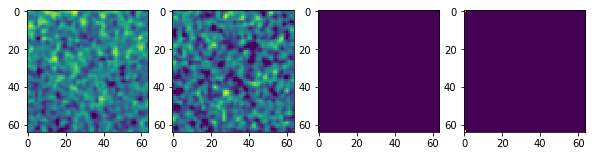

660
Training loss:  0.016937124
Validation loss:  0.07210905


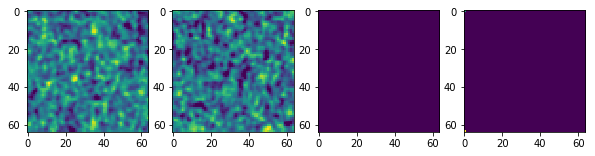

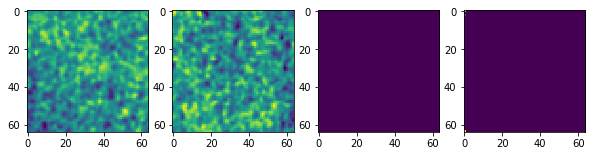

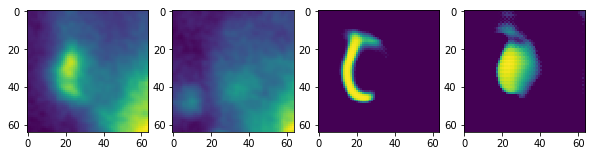

690
Training loss:  0.023256587
Validation loss:  0.09178736


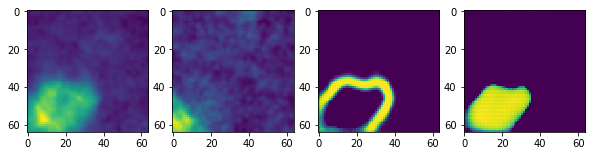

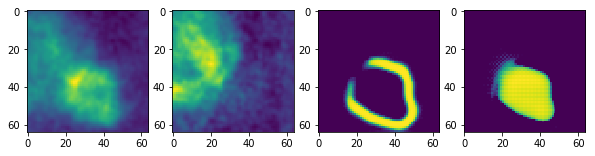

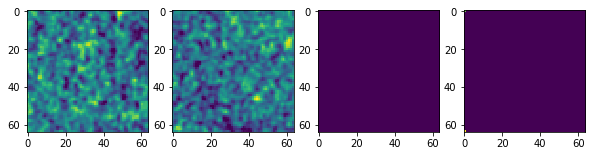

720
Training loss:  0.018739257
Validation loss:  0.093567036


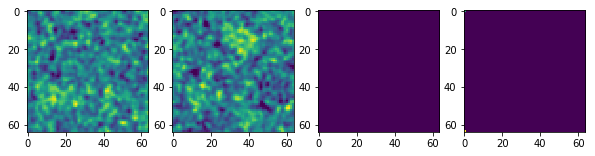

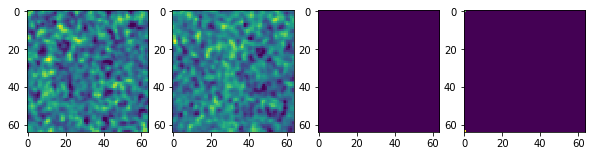

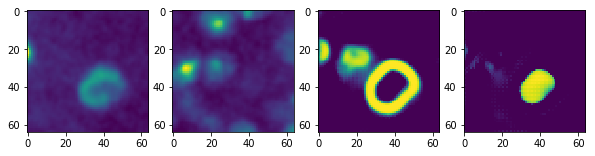

750
Training loss:  0.013968101
Validation loss:  0.08366164


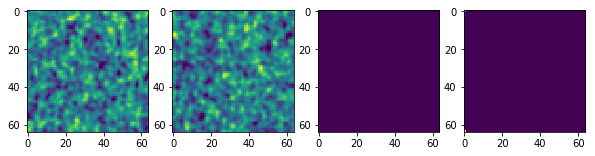

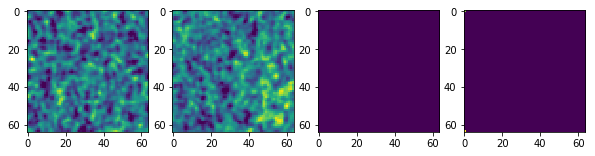

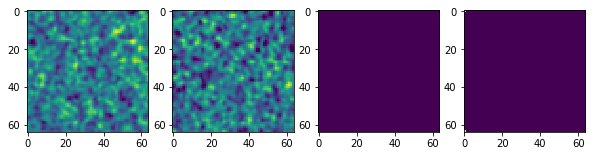

780
Training loss:  0.015541455
Validation loss:  0.0664498


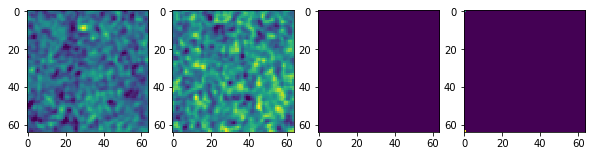

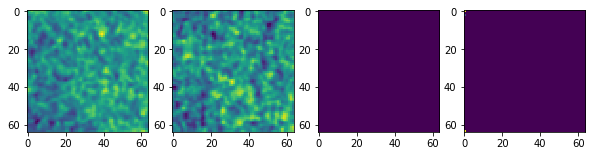

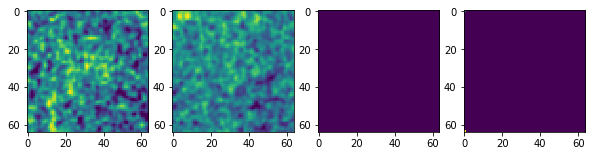

810
Training loss:  0.013634884
Validation loss:  0.072103344


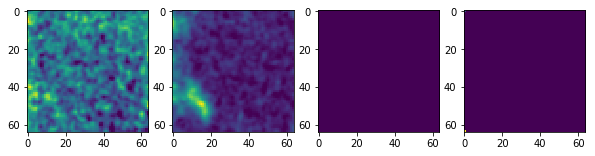

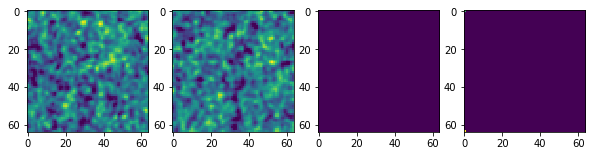

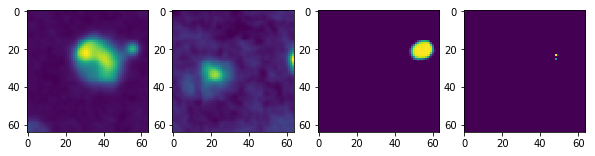

840
Training loss:  0.0144710485
Validation loss:  0.083165005


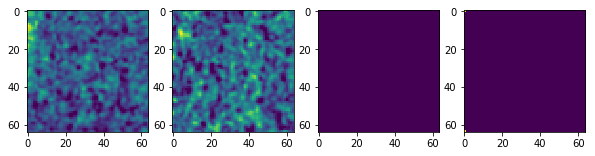

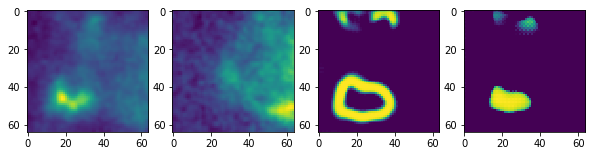

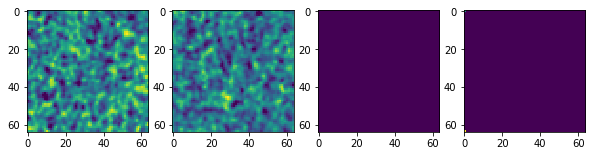

870
Training loss:  0.011278856
Validation loss:  0.0859481


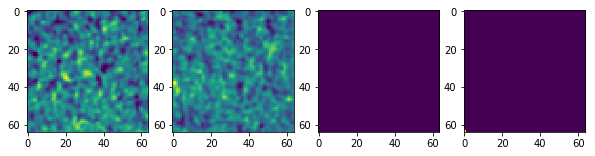

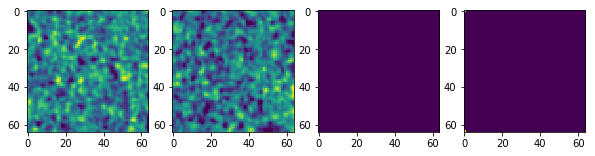

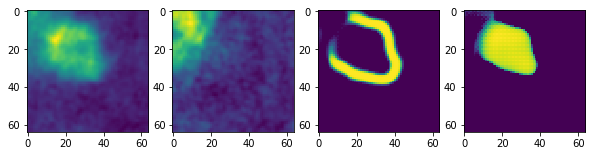

900
Training loss:  0.010366089
Validation loss:  0.0892844


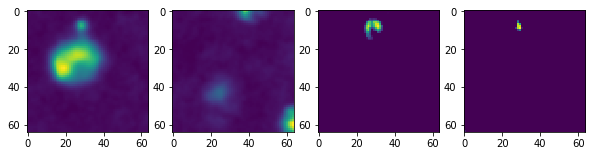

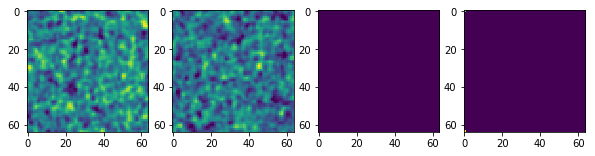

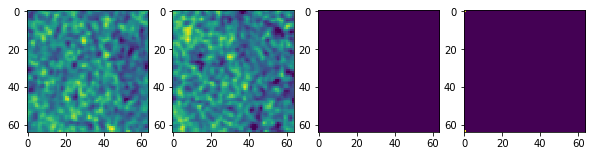

KeyboardInterrupt: 

In [131]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(20000):
    idx=np.random.choice(training_list.shape[0], replace=False, size=[400])
    cur_train=training_list[idx,:,:,:]
    cur_truth=training_truth[idx,:,:,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%30==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_list.shape[0], replace=False, size=[300])
        #idx=range(0,300)
        sub_validation_data=validation_list[idx, :,:,:]
        sub_validation_truth=validation_truth[idx, :,:,:]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print("Validation loss: ",losses)
        ti=202
        plot_4x1(sub_validation_data[ti,:,:,0], sub_validation_data[ti,:,:,1], results[ti,:,:,0], results[ti,:,:,1])
        plt.show()
        ti=203
        plot_4x1(sub_validation_data[ti,:,:,0], sub_validation_data[ti,:,:,1], results[ti,:,:,0], results[ti,:,:,1])
        plt.show()
        ti=204
        plot_4x1(sub_validation_data[ti,:,:,0], sub_validation_data[ti,:,:,1], results[ti,:,:,0], results[ti,:,:,1])
        plt.show()
        #f,axes=plt.subplots(2,2, figsize=(8,8))
        #ix=np.random.randint(0,100)
        #axes[0,0].imshow(sub_validation_data[ix,:,:,0])
        #axes[0,1].imshow(a[ix,:,:,1])
        #axes[1,0].imshow(a[ix,:,:,2])
        #axes[1,1].imshow(a[ix,:,:,3])
        #print([results[ix,0], sub_validation_truth[ix,0]])
        #plt.show()

# Look at validation data

In [132]:
idx=np.random.choice(validation_list.shape[0], replace=False, size=[200])
idx=range(9200,9500)
sub_validation_data=validation_list[idx, :,:,:]
sub_validation_truth=validation_truth[idx, :,:,:]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.06350895

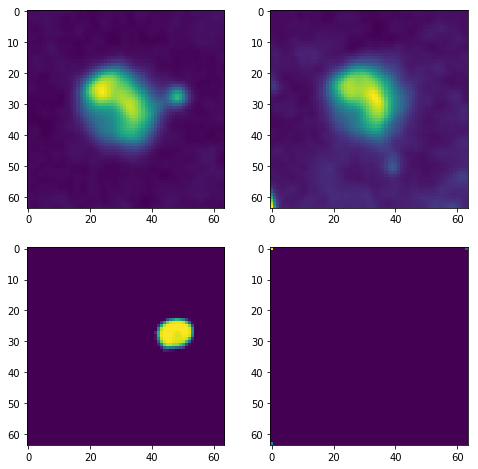

In [134]:
ix=random.randint(0,100)
utils.plot_2x2(sub_validation_data[ix,:,:,0], sub_validation_data[ix,:,:,2], results[ix,:,:,0], results[ix,:,:,1])

# Look at whole image bone 2 13 081516

In [45]:
for s in range(3,7):
    curfile='test'+str(s)
    true_test2_data=get_raw_float_image(data+curfile+'.raw', shp)[:,:,:,0:3]
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,3])
    process_batch_size=8000
    print(curfile)
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        sub_validation_truth=validation_truth[0:sub_validation_data.shape[0], :]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        output[t:(t+process_batch_size)]=results[:,:]
    np.savetxt(data+curfile+'a.txt', output[:,0])
    np.savetxt(data+curfile+'b.txt', output[:,1])

test3
test4
test5
test6


In [139]:
true_test2_data=get_raw_float_image(data+'test5.raw', shp)[:,:,:,0:3]/4096.0


In [140]:
num_images=true_test2_data.shape[0]
output=np.zeros([num_images,64,64,2])
process_batch_size=200

In [141]:
for t in range(0,num_images,process_batch_size):
    endrng=np.min((t+process_batch_size,num_images))
    sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
    sub_validation_truth=validation_truth[0:sub_validation_data.shape[0], :,:,:]
    results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
    output[t:(t+process_batch_size)]=results


In [142]:
output=np.swapaxes(np.swapaxes(output,3,2),2,1)
(output*255.0).astype(np.uint8).tofile(data+'test5_output.raw')

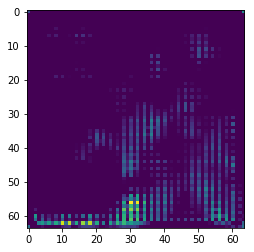

In [91]:
plt.imshow(output[58840,:,:,1])

In [88]:
np.min(output)

0.0

In [85]:
output.shape

(64821, 64, 64, 2)

In [186]:
np.savetxt('/home/ubuntu/SAS_StemCell/test6b.txt', output)

IndexError: index 7067 is out of bounds for axis 0 with size 821

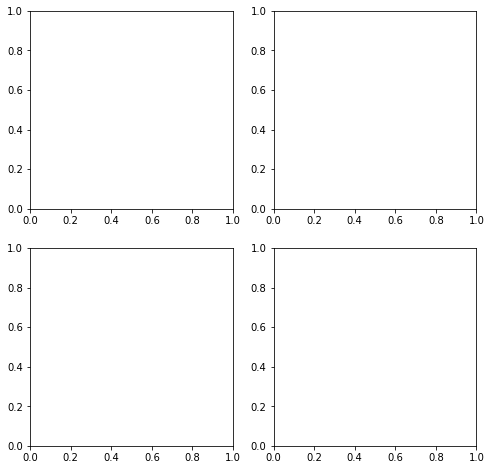

In [106]:
ix=7067
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

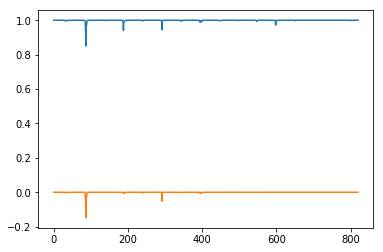

In [125]:
plt.plot(results[:,2]-0*results[:,1])
plt.plot(-results[:,1])



In [133]:
np.max(np.sum(results, axis=1))

1.0000001

In [144]:
saver=tf.train.Saver()

In [145]:
saver.save(sess, data+"modelv2.ckpt")

'/home/ubuntu/SAS_StemCell/modelv2.ckpt'